# Lab 3: 반복 위상 추정(Iterative phase estimation)

양자 위상 추정 (QPE, Quantum Phase Estimation) 알고리듬은 양자 알고리듬 중 가장 중요하고 유명한 것 중 하나입니다. 이 것은 쇼어의 소인수분해 알고리듬이나 양자 시뮬레이션의 알고리듬들의 핵심적인 하위 루틴입니다. Qiskit Textbook에 소개된 쇼어 알고리듬은 원하는 정밀도를 얻기 위해 여러개의 보조 큐비트들을 사용하는데, 이는 현재의 노이즈가 존재하는 양자 컴퓨터에서 실행하기에는 큐비트의 숫자와 연결성 부분에서 도전적입니다.

반복 위상 추정(IPE: Iterative Phase Estimation)은 QPE의 일종으로 오직 하나의 보조 큐비트만을 사용합니다. IPE에서, 보조 큐비트는 반복 측정되며, 측정 결과는 다음 양자 연산을 이끄는데 사용 됩니다. 동적 회로(Dynamic Circuit)가 탄생하기 전에는, 이런 고적적인 피드포워드(feed-forward)는 IBM의 양자 하드웨어에서 실행이 불가능 했습니다.

이번 랩에서는, 동적 회로의 기능을 IPE를 구현하는 데 사용해 보도록 하겠습니다.

## 배경지식

다른 추정 알고리듬들과 같이, IPE는 다음의 문제들을 해결하기 위해 설계되었습니다:

**문제의 정의:** 주어진 유니터리 행렬 $U$과 그것의 미지의 고유값(eigenvalue) $e^{i 2\pi \varphi}$을 갖는 고유상태(eigenstate)$|\Psi\rangle$가 주어졌을 때, $\varphi$를 추정해 냅니다.


문제의 정의 부분에는 몇 가지 중요한 세부 사항, 즉 $U$ 및 $|\Psi\rangle$이 어떻게 구체화 되는지를 명확히 해야 합니다. 보통 $U$가 $U$를 구현하는 양자 회로로 주어지며 실제로 양의 정수 $t$에 대해 *controlled*-$U^{2^t}$ 연산을 효율적으로 구현할 수 있다고 가정합니다.
이는 원래 QPE 알고리즘에서 사용된 것과 동일한 가정입니다.
동일한 가정은 고유 상태또한 양자 회로로 만들수 있다고 적용됩니다: $|\Psi\rangle$을 효율적으로 마련할 수 있다고 가정합니다

우선 가장 먼저 $\varphi$가 2진법으로 확장(binary expansion)이 가능하다고 단순하게 가정해 봅시다, 즉, 다음과 같이 작성할 수 있습니다:

$$
\varphi = \varphi_1/2 + \varphi_2/4 + \cdots + \varphi_m/2^m = 0.\varphi_1 \varphi_2 \cdots \varphi_m
$$.
이때, 최종 등식에서 십진법의 점 표기법을 2진 기저에 사용함을 기억합니다.

단순화를 위해 $U$가 하나의 큐비트에서 작동하는 유니터리 연산자라고 가정합니다(여기서 말하는 모든 내용은 $U$가 여러 큐비트에서 작동하는 경우에도 적용됨). IPE에는 보조 큐비트가 필요하므로 $q_0$ 및 $q_1$의 두 큐비트 시스템이 필요합니다. 여기서 $q_0$는 보조 큐비트이고 $q_1$는 $U$가 작동하는 물리적 시스템을 나타냅니다.

이제, $q_0$를 $|+\rangle = \frac{|0\rangle + |1\rangle}{\sqrt{2}}$ 로 $q_1$ 을 $|\Psi \rangle$로 초기화 한다고 생각해봅시다. 

만약 *controlled*-$U^{2^t}$게이트를 $q_0$를 제어 큐비트로, $q_1$을 대상 큐비트로 삼아서 적용한다면 무슨 일이 발생할 지 생각해 봅시다. 
$|\Psi \rangle$이  고유값 $e^{i 2\pi \varphi}$을 지니는 $U$의 고유상태라면,

$$
\begin{align}
|+\rangle |\Psi \rangle &= \left(\frac{|0\rangle + |1\rangle}{\sqrt{2}}\right) |\Psi \rangle \\
&= \frac{|0\rangle |\Psi \rangle + |1\rangle |\Psi \rangle}{\sqrt{2}} \\
&\xrightarrow{\text{controlled-}U^{2^t}} \frac{|0\rangle |\Psi \rangle + e^{i 2 \pi 2^{t} \varphi} |1\rangle |\Psi \rangle}{\sqrt{2}} \\
&= \left(\frac{|0\rangle  + e^{i 2 \pi 2^{t} \varphi} |1\rangle}{\sqrt{2}}\right) |\Psi \rangle.
\end{align}
$$

즉, 시스템 큐비트의 상태는 변하지 않으면서 $e^{i 2 \pi 2^{t} \varphi}$의 위상 값이 반동(kicked back)되어 보조 큐비트에 쓰여지게 됩니다. 


이제, 다음을 살펴봅시다.

$$
e^{i 2 \pi 2^{t} \varphi} = e^{i 2 \pi 2^{t} (0.\varphi_1 \varphi_2 \cdots \varphi_m)}
= e^{i 2 \pi (\varphi_1 \cdots \varphi_t . \varphi_{t + 1} \cdots \varphi_m)}
= e^{i 2 \pi (0. \varphi_{t + 1} \cdots \varphi_m)},
$$

마지막 등식에서, "10"진법으로 기록된 전체 숫자 부분은 임의의 $n$에 대하여 $e^{i 2\pi n} = 1$을 만족하여 사라지게 됩니다. 

예를 들어:
- $t=0$이면, 위상은 $e^{i 2 \pi 2^{0} \varphi} = e^{i 2 \pi \varphi} = e^{i 2 \pi 0.\varphi_1 \varphi_2 ... \varphi_m}$ 입니다.
- $t=1$이면, 위상은 $e^{i 2 \pi 2^{1} \varphi}= e^{i 2 \pi \varphi_1} e^{i 2 \pi 0.\varphi_2 \varphi_3 ... \varphi_m} = e^{i 2 \pi 0.\varphi_2 \varphi_3 ... \varphi_m}$ 입니다.
- $t=2$이면, 위상은  $e^{i 2 \pi 2^{2} \varphi} = e^{i 2 \pi 0.\varphi_3 \varphi_4 ... \varphi_m}$ 입니다.
- $t=m-1$이면, 위상은 $e^{i 2 \pi 2^{m-1} \varphi} = e^{i 2 \pi 0.\varphi_m}$ 입니다.

마지막 경우인 $t = m - 1$에서, $\varphi_m = 0$이면 위상은 $1$과 같은 $e^{i 2 \pi 0.\varphi_m}$이고, $\varphi_m = 1$이면 $-1$이 됩니다. 

첫번째 경우에서, 보조 큐비트 $q_0$는 $|+\rangle = \frac{|0\rangle + |1\rangle}{\sqrt{2}}$의 상태가 되고, 두번째 경우에는 $|-\rangle = \frac{|0\rangle - |1\rangle}{\sqrt{2}}$가 됩니다. 
그러므로, 큐비트를 파울리 $X$기저로 측정하게 되면, 이 상태들을 100%의 성공 확률로 구분할 수 있게 됩니다. 

이 작업은 측정 전 큐비트에 하다마드 게이트를 적용하는 것으로 구현할 수 있습니다. 첫번째 경우에는 0을 측정하게 될 것이고, 두번째 경우에는 1을 측정하게 될 것입니다.
다시 말해, 측정 비트는 $\varphi_m$와 같습니다. 


### 알고리듬

IPE의 첫번째 단계에서, 위에서 설명한 대로 2큐비트 레지스터를 초기화하여( $q_0 \rightarrow |+\rangle$ 및 $q_1 \rightarrow |\Psi \rangle $ ) *colntrolled*-$U^{2^{m-1}}$ 연산을 적용한 후 Pauli $X$ 기저로 $q_0$를 측정하여 위상 $\varphi$, $\varphi_m$의 최하위 비트를 직접 측정합니다. 

두번째 단계에서, 시스템을 같은 방법으로 초기화 한후 *controlled*-$U^{2^{m-2}}$ 연산을 적용합니다. 이 연산들 후에 $q_0$의 상대 위상(relative phase)은 $e^{i 2 \pi 0.\varphi_{m-1}\varphi_{m}}= e^{i 2 \pi 0.\varphi_{m-1}} e^{i 2 \pi \varphi_m/4}$이 됩니다. 
위상 비트 $\varphi_{m-1}$를 추출하기 위해, 우선 $Z$축을 기준으로  $q_0$를 $|0\rangle + e^{i 2 \pi 0.\varphi_{m-1}} | 1 \rangle$로 만드는 $-2 \pi \varphi_m/4=-\pi \varphi_m/2$ 회전을 적용해 위상을 보정합니다. $q_0$을 파울리 $X$ 기저로 측정해 위상 비트 $\varphi_{m-1}$를 얻습니다.  

그러므로, $\varphi_{m-k+1}$를 얻는 IPE의 $k$번째 단계는, 레지스터 초기화 ($q_0$를 $|+\rangle$, $q_1$를 $|\Psi\rangle$), *controlled*-$U^{2^{m-k}}$의 적용, $Z$축 기준의 $\omega_k = -2 \pi 0.0\varphi_{m-k+2} ... \varphi_m$ 각도의 회전과 $q_0$를 파울리  $X$기저로 측정: $q_0$에 하다마드 변환을 적용하고 $q_0$를 계산 기저로 측정 하는 것으로 구성됩니다.  $q_1$은 전 알고리듬의 단계에서 $|\Psi\rangle$를 유지하는 것을 기억합시다. 


## 구현

이번 랩에서는, 단일 큐비트 $S$-게이트에 IPE를 적용해보겠습니다. $S$ 게이트는 다음과 같은 행렬식으로 정의됩니다. 

$$ S =
\begin{bmatrix}
1 & 0\\\\
0 & e^{i\pi / 2}\\\\
\end{bmatrix}$$

고유값 $e^{i\pi / 2}= e^{i2\pi \cdot 1/4}$을 갖는 고유상태 $|\Psi\rangle = |1\rangle$를 사용할 것입니다. 또한 $\varphi = 1/4 = 0.01 = 0.\varphi_1 \varphi_2$를 사용합니다. $\varphi$가 2비트로 표현될 수 있기 때문에, 양자 회로의 구현은 결과를 저장하기 위해 두개의 고전 레지스터를 사용합니다. 


controlled-$S$ 게이트는 Qiskit에서 `CPhaseGate`로 정의된 제어 위상 게이트를 사용해서 구현하며, 이 게이트는 `QuantumCircuit`의 `cp` 연산을 호출하여 사용합니다. 제어 위상 게이트는 $\theta$로 매개변수화(parameterized) 되며 행렬식은 다음과 같습니다. 

$$
        \text{CPhase}(\theta) =
            \begin{pmatrix}
                1 & 0 & 0 & 0 \\
                0 & 1 & 0 & 0 \\
                0 & 0 & 1 & 0 \\
                0 & 0 & 0 & e^{i\theta}
            \end{pmatrix}
$$


###  1 단계

알고리듬의 첫번째 단계는, $\varphi$의 최하위비트를 측정합니다. 


#### 연습 1

$\varphi$의 최하위비트를 다음의 단계를 따라 얻습니다:
1. 큐비트 초기화:
   - 보조 큐비트에 하다마드 게이트 적용
   - 시스템 큐비트에 X 게이트를 적용해 $|1\rangle$ 상태 만들기 
2. *controlled*-$S^{2}$ 게이트를 `CPhaseGate`에 적절한 각도를 설정해 구현
3. 보조 큐비트를 $X$ 기저로 측정:
   - 하다마드 게이트를 보조 큐비트에 적용
   - 계산 기저로 측정

최종 회로는 다음과 같습니다:

![step1-circuit](resources/step1-circuit.png)

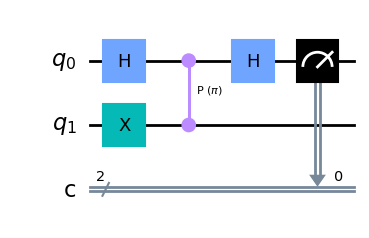

In [12]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
import numpy as np


def step_1_circuit(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 2 bits

    qc = QuantumCircuit(qr, cr)

    ####### your code goes here #######
    
    qc.h(qr[0])
    qc.x(qr[1])
    qc.cp(np.pi, qr[1], qr[0])
    qc.h(qr[0])
    qc.measure(qr[0], cr[0])

    return qc


qr = QuantumRegister(2, "q")
cr = ClassicalRegister(2, "c")
qc = QuantumCircuit(qr, cr)
qc = step_1_circuit(qr, cr)
qc.draw("mpl")

In [13]:
# Submit your circuit

from qc_grader.challenges.spring_2023 import grade_ex3a

grade_ex3a(qc)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


###  2 단계

첫번째 단계에서, 최하위 비트 $\varphi_2$를 측정했습니다. 두 번째(이자 마지막) 단계에서는, 다음 비트이자 위상 보정을 적용해 $\varphi_2$로부터의 기여도를 제거할 $\varphi_1$를 얻습니다. 위상 보정은 $\varphi_2$의 값을 갖는 고전 비트의 값에 따라 결정됩니다. 동적  회로가 바로 여기에서 고전적 피드백을 위해 사용됩니다! 위상 보정은 `PhaseGate` 혹은 QuantumCircuit의 `p` 함수를 바로 호출하여 구현할 수 있습니다.

#### 연습 2

이번 연습은 연습1에서 구현한 1단계의 회로로 부터 시작합니다. 

$\varphi$의 다음 비트를 얻기 위해서 다음의 과정을 밟습니다:
1. 보조 큐비트를 초기화 하고 다시 초기값을 입력
2. 제어 유니터리 게이트를 적용
3. 보조 큐비트를 $X$ 기저로 측정

최종적으로 만들어질 회로는 다음과 같습니다.

![step1-circuit](resources/step2-circuit.png)

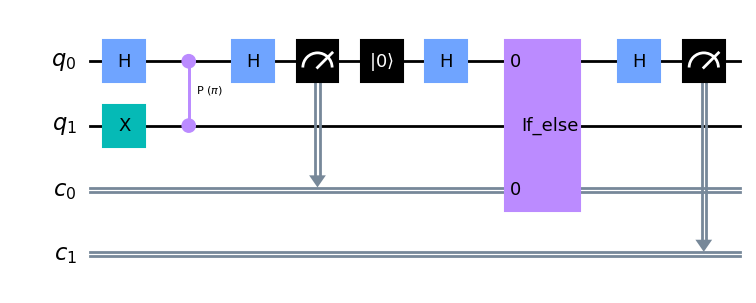

In [14]:
def step_2_circuit(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 2 bits

    # begin with the circuit from Step 1
    qc = step_1_circuit(qr, cr)

    ####### your code goes here #######
    
    qc.reset(qr[0])
    qc.h(qr[0])
    with qc.if_test((cr[0], 0)):
        qc.p(np.pi/2, qr[0])
    qc.h(qr[0])
    qc.measure(qr[0], cr[1])

    return qc


qr = QuantumRegister(2, "q")
cr = ClassicalRegister(2, "c")
qc = QuantumCircuit(qr, cr)
qc = step_2_circuit(qr, cr)
qc.draw("mpl")

In [15]:
# Submit your circuit

from qc_grader.challenges.spring_2023 import grade_ex3b

grade_ex3b(qc)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


## 시뮬레이터로 실행

회로가 완성되었으니, 먼저 로컬 시뮬레이터를 사용해 실행해 봅시다.

In [16]:
from qiskit_aer import AerSimulator

sim = AerSimulator()
job = sim.run(qc, shots=1000)
result = job.result()
counts = result.get_counts()
counts

{'01': 1000}

여러분의 회로가 잘 만들어졌다면, `01`을 100%의 확률로 얻게 될 것입니다. 이 바이너리 값은 $\varphi = 0.01 = 1/4$의 위상에 해당합니다. 즉, 정확한 위상 값을 얻었습니다!

### 연습 3

T 게이트의 위상을 추정하는 IPE 회로를 작성해 봅시다. T 게이트의 행렬식은 다음과 같습니다. 

$$ T =
\begin{bmatrix}
1 & 0\\\\
0 & e^{i\pi / 4}\\\\
\end{bmatrix}$$

이 경우 위상을 표현하기 위해 몇 개의 큐비트가 필요할까요?

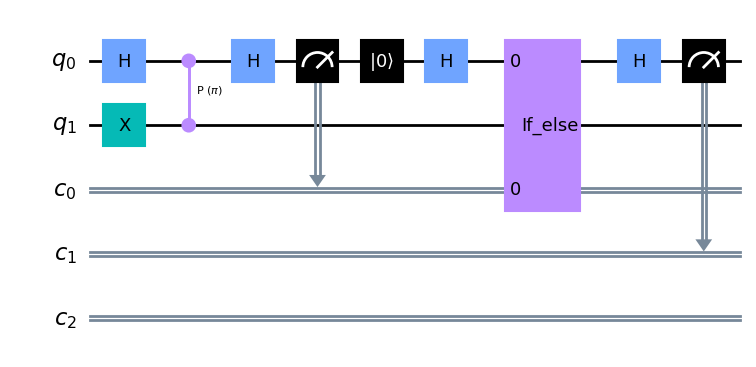

In [19]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
import numpy as np


def t_gate_ipe_circuit(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 3 bits

    qc = QuantumCircuit(qr, cr)

    ####### your code goes here #######
    
    qc.h(qr[0])
    qc.x(qr[1])
    qc.cp(np.pi, qr[1], qr[0])
    qc.h(qr[0])
    qc.measure(qr[0], cr[0])
    qc.reset(qr[0])
    qc.h(qr[0])
    with qc.if_test((cr[0], 0)):
        qc.p(np.pi/2, qr[0])
    qc.h(qr[0])
    qc.measure(qr[0], cr[1])

    return qc


qr = QuantumRegister(2, "q")
cr = ClassicalRegister(3, "c")
qc = QuantumCircuit(qr, cr)
qc = t_gate_ipe_circuit(qr, cr)
qc.draw("mpl")

In [20]:
from qiskit_aer import AerSimulator

sim = AerSimulator()
job = sim.run(qc, shots=1000)
result = job.result()
counts = result.get_counts()
counts

{'001': 1000}

In [21]:
# Submit your circuit

from qc_grader.challenges.spring_2023 import grade_ex3c

grade_ex3c(qc)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


### 구하고자 하는 위상이 정확히 2진법으로 표현되지 않을 때

구하고자 하는 위상이 정확히 2진법으로 표현되지 않는 경우, 예를 들어 $\varphi = 1/3$인 경우를 생각해 봅시다. 
이 경우, 단일 큐비트 게이트의 유니터리는 가 됩니다.

$$ U =
\begin{bmatrix}
1 & 0\\\\
0 & e^{i2\pi / 3}\\\\
\end{bmatrix}
$$

각도 $\varphi = 1/3$는 이진법으로 정확히 표현되지 못합니다. 반대로 이 각도는 무한의 2진법 표현을 갖습니다. 

$$
1/3 = 0.010101\ldots
$$

고정된 정밀도의 비트의 수를 사용해야 하는 연습에서, 여러분의 목표는 이 비트들을 사용해 얻을 수 있는 가장 가까운 값을 얻는 것입니다.
이어지는 연습에서, 두개의 비트만큼의 정밀도를 사용 할 것입니다. 이 경우, 가장 가까운 값은 $0.01 = 1/4$입니다. 이 값이 정확한 위상을 표현하지 못하고 있기 때문에, 덜 정확하고, 실제와는 조금 다른 결과를 얻을 가능성이 존재합니다. 


이어지는 코드셀에서, 이 게이트의 위상을 측정하는 IPE 회로를 구성해 봅시다.


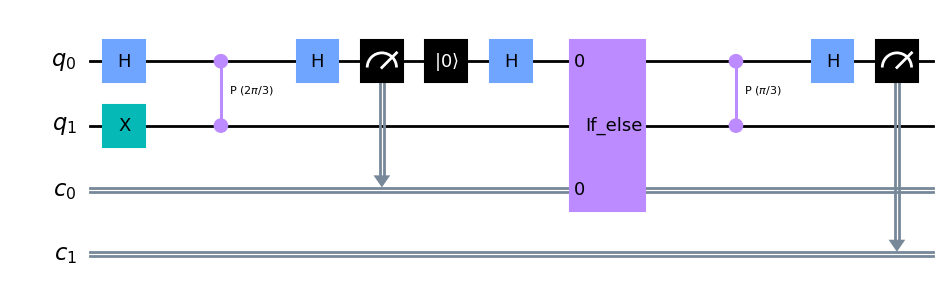

In [22]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
import numpy as np


def u_circuit(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 2 bits

    qc = QuantumCircuit(qr, cr)

    # Initialization
    q0, q1 = qr
    qc.h(q0)
    qc.x(q1)

    # Apply control-U operator as many times as needed to get the least significant phase bit
    u_angle = np.pi / 3
    k = 1
    cphase_angle = u_angle * 2**k
    qc.cp(cphase_angle, q0, q1)

    # Measure the auxiliary qubit in x-basis into the first classical bit
    qc.h(q0)
    c0, c1 = cr
    qc.measure(q0, c0)

    # Reset and re-initialize the auxiliary qubit
    qc.reset(q0)
    qc.h(q0)

    # Apply phase correction conditioned on the first classical bit
    with qc.if_test((c0, 1)):
        qc.p(-np.pi / 2, q0)

    # Apply control-U operator as many times as needed to get the next phase bit
    k = 0
    cphase_angle = u_angle * 2**k
    qc.cp(cphase_angle, q0, q1)

    # Measure the auxiliary qubit in x-basis into the second classical bit
    qc.h(q0)
    qc.measure(q0, c1)

    return qc


qr = QuantumRegister(2, "q")
cr = ClassicalRegister(2, "c")
qc = QuantumCircuit(qr, cr)
qc = u_circuit(qr, cr)
qc.draw("mpl")

In [23]:
from qiskit_aer import AerSimulator

sim = AerSimulator()
job = sim.run(qc, shots=1000)
result = job.result()
counts = result.get_counts()
print(counts)
success_probability = counts["01"] / counts.shots()
print(f"Success probability: {success_probability}")

{'10': 64, '00': 187, '11': 65, '01': 684}
Success probability: 0.684


확인한 것 처럼, 이번에는, 원하는 결과를 확실히 얻지 못했습니다. 자연스러운 질문이 생깁니다: 성공 확률을 어떻게 끌어 올릴 수 있을까요?

알고리듬이 실패하게 되는 한가지 원인은 첫번째 측정된 비트가 정확하지 않은 것입니다. 이 경우 두번째 비트를 측정하기 전에 적용되는 위상 보정도 정확하지 않기 때문에 나머지 비트들도 부정확하게 되어 있습니다. 이 문제를 완화하는 가장 간단한 방법은 처음 몇 비트의 측정을 여러번 반복한 후 가장 여러번 나타난 결과를 선택해(majority vote) 측정의 정확도를 높이는 것입니다. 단일 회로에서 이 과정을 구현하귀해서는 측정된 결과에 대해 산술연산을 수행해야 합니다. 일시적인 Qiskit의 상황으로 인해 현재 측정된 비트에 대해 산술 여산을 수행하고 결과에 따라 다음의 회로 연산에 조건을 적용하는 것은 불가능합니다. 따라서 여기에서는 각각의 비트를 별도의 회로들을 사용해 측정하도록 하겠습니다. 

이어지는 코드셀은 위상의 첫번째 비트만을 측정하는 IPE 회로를 구성하고 시뮬레이션 합니다.


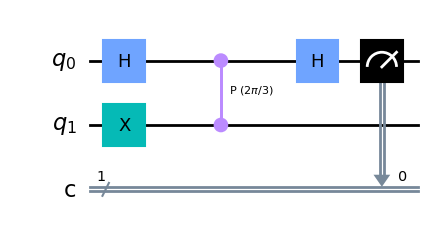

In [24]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
import numpy as np


def u_circuit(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 1 bits

    qc = QuantumCircuit(qr, cr)

    # Initialization
    q0, q1 = qr
    qc.h(q0)
    qc.x(q1)

    # Apply control-U operator as many times as needed to get the least significant phase bit
    u_angle = np.pi / 3
    k = 1
    cphase_angle = u_angle * 2**k
    qc.cp(cphase_angle, q0, q1)

    # Measure the auxiliary qubit in x-basis
    qc.h(q0)
    (c0,) = cr
    qc.measure(q0, c0)

    return qc


qr = QuantumRegister(2, "q")
cr = ClassicalRegister(1, "c")
qc = QuantumCircuit(qr, cr)
qc = u_circuit(qr, cr)
qc.draw("mpl")

In [25]:
job = sim.run(qc, shots=15)
result = job.result()
counts = result.get_counts()
print(counts)

{'0': 7, '1': 8}


우리의 바램은, 바른 결과의 비트가 그렇지 않은 것보다 더 자주 측정되는 것입니다. 

### 연습 4

마지막 코드 셀의 출력에서 카운트 사전을 검사합니다. 첫 번째 비트의 올바른 값은 무엇입니까? 측정을 안 한 것보다 더 자주 했나요? 그렇지 않은 경우 마지막 코드 셀을 다시 실행합니다. 그런 다음 아래의 코드 셀에 'step1_bit' 변수를 대부분 측정된 비트 값과 동일하게 설정하는 코드를 작성합니다.
코드 셀의 마지막에서 계산 결과의 카운트 결과(Dictionary 타입)를 검토합니다. 첫번째 비트의 올바른 값은 무었일까요? 올바른 값은 그렇지 않은 경우보다 더 자주 측정되었나요? 그렇지 않다면, 마지막 코드셀을 다시 실행해 봅시다. 그 다음, 아래의 코드셀의 `step1_bit`에 주로 측정된 비트의 값을 설정하는 코드를 작성해 봅시다.


In [26]:
step1_bit: int

####### your code goes here #######

step1_bit = 0
if counts['0'] <= counts['1']:
    step1_bit = 1

print(step1_bit)

1


In [27]:
# Submit your result

from qc_grader.challenges.spring_2023 import grade_ex3d

grade_ex3d(step1_bit)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


### 연습 5

이제 위상의 두 번째 비트를 측정하기 위한 회로를 구성합니다. 여기서는 회로의 첫 번째 단계를 위에서 측정한 값으로 보조 비트를 설정하는 것으로 수정하여 항상 위상의 첫 번째 비트에 대한 올바른 측정 값을 갖도록 합니다.


In [ ]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
import numpy as np


def u_circuit(qr: QuantumRegister, cr: ClassicalRegister) -> QuantumCircuit:
    # qr is a quantum register with 2 qubits
    # cr is a classical register with 2 bits

    qc = QuantumCircuit(qr, cr)

    ####### your code goes here #######

    return qc


qr = QuantumRegister(2, "q")
cr = ClassicalRegister(2, "c")
qc = QuantumCircuit(qr, cr)
qc = u_circuit(qr, cr)
qc.draw("mpl")

In [ ]:
# Submit your result

from qc_grader.challenges.spring_2023 import grade_ex3e

grade_ex3e(qc)

In [ ]:
from qiskit_aer import AerSimulator

sim = AerSimulator()
job = sim.run(qc, shots=1000)
result = job.result()
counts = result.get_counts()
print(counts)
success_probability = counts["01"] / counts.shots()
print(f"Success probability: {success_probability}")

이번엔 성공 확률이 이전보다 확실히 증가했습니다!

## 하드웨어 실행


이 랩의 마무리를 위해, 실제 하드웨어에서 회로들을 실행해 보도록 합시다! 아래의 코드셀은 연습 2에서 만든 회로를 초기화 하고 실행하여 $S$ 게이트의 위상을 측정합니다. 현재의 양자 하드웨어는 노이즈를 지니고 있기 때문에, 결과는 시뮬레이터를 통해 얻은 것 만큼 좋지 않을 것입니다. $T$ 게이트의 위상을 측정하기 위한 연습 3의 회로와 같이 더 큰 회로는 더 많은 노이즈의 영향을 받을 것을 염두에 두고 더 많은, 다양한 회로를 실행해 봅시다. 


In [ ]:
from qiskit_ibm_provider import IBMProvider

provider = IBMProvider()

In [ ]:
hub = "YOUR_HUB"
group = "YOUR_GROUP"
project = "YOUR_PROJECT"

backend_name = "ibm_peekskill"
backend = provider.get_backend(backend_name, instance=f"{hub}/{group}/{project}")

In [ ]:
from qiskit import transpile

qr = QuantumRegister(2, "q")
cr = ClassicalRegister(2, "c")
qc = QuantumCircuit(qr, cr)
qc = step_2_circuit(qr, cr)
qc_transpiled = transpile(qc, backend)

In [ ]:
job = backend.run(qc_transpiled, shots=1000, dynamic=True)
job_id = job.job_id()
print(job_id)

job_id를 통해 실행된 작업을 불러들이고 실행 상태를 점검해 봅시다.

In [ ]:
retrieve_job = provider.retrieve_job(job_id)
retrieve_job.status()

작업이 완료되었다면 결과를 불러들여봅시다.

In [ ]:
from qiskit.tools.visualization import plot_histogram

counts = retrieve_job.result().get_counts()
plot_histogram(counts)

이 연습문제는[Qiskit Textbook lab](https://learn.qiskit.org/course/ch-labs/lab-6-iterative-phase-estimation-algorithm)의 Iterative Phase estimation 과 [dynamic circuits documentation](https://quantum-computing.ibm.com/services/resources/docs/resources/manage/systems/dynamic-circuits/Getting-started-with-Dynamic-Circuits)을 사용해 만들어 졌습니다.